In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report
plt.style.use('ggplot')


#nlp related
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from collections import  Counter
from collections import defaultdict

np.random.seed(42)
tf.random.set_seed(42)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b/glove.6B.200d.txt
/kaggle/input/glove6b/glove.6B.50d.txt
/kaggle/input/glove6b/glove.6B.300d.txt
/kaggle/input/glove6b/glove.6B.100d.txt
/kaggle/input/nlptweet/train.csv
/kaggle/input/nlptweet/test.csv
/kaggle/input/tweet-test-sub/submission.csv
/kaggle/input/glovetwitter27b100dtxt/glove.twitter.27B.200d.txt


### Step 1 Brief description of the problem and data (5 pts)
Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.

This problem require us to classify twitter post are weather announcing a disaster or describe the sense by using metaphor. In NLP. this is a typical semantic analysis problem. Other applications like classify user's text  comment into binary positive or negative. 

In this problem, we have access of 10,000 samples of tweets with labels, our goal is to preprocess the data, choose a word embedding method and build a binary classification output.

-------------------------------------------------

### Step 2 Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

In [2]:
train = pd.read_csv('../input/nlptweet/train.csv')
test_submit = pd.read_csv('../input/nlptweet/test.csv')

print(train.shape, test_submit.shape)
train.head()

(7613, 5) (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test_submit.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Let's visulize number of positive and negetive tragets.

Two classes are not balance, type 0 are 33% more than type 1.

0    4342
1    3271
Name: target, dtype: int64
Class 0 are 32.7 % more than class 1


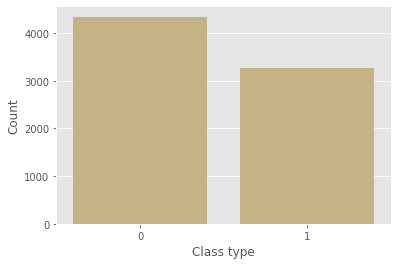

In [4]:
count = train.target.value_counts()
sns.barplot(x=count.index, y=count, color='#CFB87C')
print(count)
plt.ylabel("Count")
plt.xlabel("Class type")
print('Class 0 are', 100*round((count[0]-count[1])/count[1],3), '% more than class 1')

More EDA

Some natural questions to ask: 
* What is the length of each tweet's distribution in the dataset. Difference in target=0 and target=1?
* Most common words? And how they differ in two type?
* Most common special symbols?

Data cleaning:
* Removing special symbols like '@','#', urls, emojis.
* Correctting misspelling, because incorrect spelling will have different word vector compare to correct ones.
* Conveting capital words to lowecases.
* Removing incorrect punctuations.
* Steamming
* **Result**: same logistic model, before cleaning: 68% f1 score, after cleaning 75% f1

Word length in dataset

Word counts in both type are range 0 to 30 words, approx normal distribution.

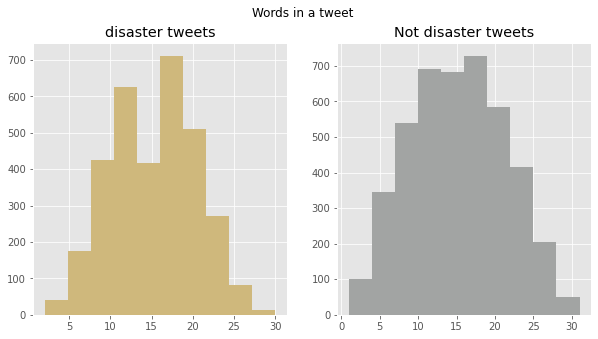

In [5]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color='#CFB87C')
ax1.set_title('disaster tweets')
tweet_len = train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='#A2A4A3')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Creat corpus, a list contain all words in datasets.

Then count and plot most common stop words in tweets.

In [6]:
def create_corpus(target, df):
    corpus=[]
    
    for x in df[df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [7]:
corpus_traget0 = create_corpus(0, train)
corpus_traget1 = create_corpus(1, train)
corpus_all = corpus_traget0 + corpus_traget1


Load stopwords list form outside module, and count most common stop words appear in our corpus. Then make a plot out of the result.

In [8]:
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))

dic = defaultdict(int)
for word in corpus_traget0:
    if word in stop:
        dic[word]+=1
        
top_0 = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

dic = defaultdict(int)
for word in corpus_traget1:
    if word in stop:
        dic[word]+=1
        
top_1 = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

Text(0.5, 1.0, 'disaster tweets')

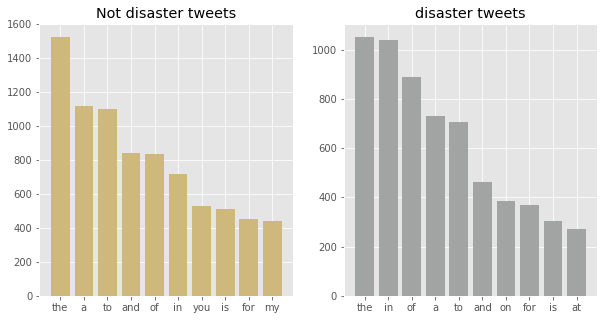

In [9]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
x,y = zip(*top_0)
ax1.bar(x,y,color='#CFB87C')
ax1.set_title('Not disaster tweets')
x,y = zip(*top_1)
ax2.bar(x,y,color='#A2A4A3')
ax2.set_title('disaster tweets')


Most common Non stop words

We can see some difference between two types, disaster contain keyword like location, 'kill', 'suicide'

In [10]:
counter = Counter(corpus_traget0)
most = counter.most_common()
x_0, y_0 = [], []
for word,count in most[:60]:
    if (word not in stop) :
        x_0.append(word)
        y_0.append(count)
        
counter = Counter(corpus_traget1)
most = counter.most_common()
x_1, y_1 = [], []
for word,count in most[:50]:
    if (word not in stop) :
        x_1.append(word)
        y_1.append(count)

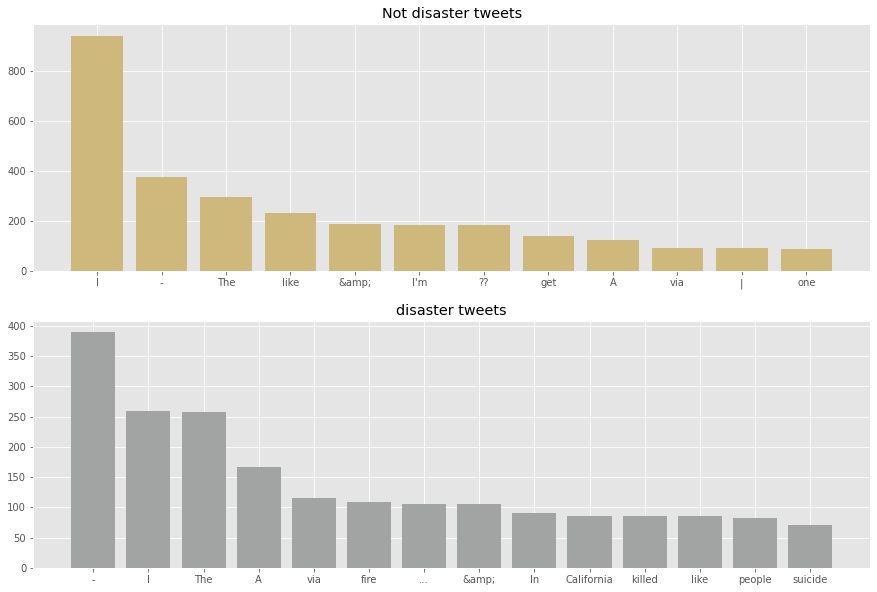

In [11]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(15,10))
ax1.bar(x_0, y_0, color='#CFB87C')
ax1.set_title('Not disaster tweets')
ax2.bar(x_1, y_1,color='#A2A4A3')
ax2.set_title('disaster tweets')
plt.show()

#### Data Cleaning

Removing urls, emojis, punctuation('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~').

In [12]:
#df = pd.concat([train,test])
print(train.shape)
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#remove_emoji("Omg another Earthquake 😔😔")
# 
def remove_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

(7613, 5)
I am a king


In [13]:
df = train
df['text'] = df['text'].apply(lambda x : remove_URL(x))
df['text'] = df['text'].apply(lambda x: remove_emoji(x))
df['text']=df['text'].apply(lambda x : remove_punct(x))
print(df.shape)

# df_full = pd.concat([train,test_submit])
# df_full['text'] = df_full['text'].apply(lambda x : remove_URL(x))
# df_full['text'] = df_full['text'].apply(lambda x: remove_emoji(x))
# df_full['text'] = df_full['text'].apply(lambda x : remove_punct(x))
# print(df_full.shape)


df_test_submit = test_submit
df_test_submit['text'] = df_test_submit['text'].apply(lambda x : remove_URL(x))
df_test_submit['text'] = df_test_submit['text'].apply(lambda x: remove_emoji(x))
df_test_submit['text'] = df_test_submit['text'].apply(lambda x : remove_punct(x))
print(df_test_submit.shape)


(7613, 5)
(3263, 4)


In [14]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1


In [15]:
#create new corpus after cleaning 
corpus_traget0 = create_corpus(0, df)
corpus_traget1 = create_corpus(1, df)
corpus_all = corpus_traget0 + corpus_traget1

list_corpus = df["text"] #.tolist()
list_labels = df["target"] #.tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, 
                                                    test_size=0.1, random_state=10)

#these are list of RAW text

### Step 3 Model Architecture (25 pts)
Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

* **Transform text into vectors: Word embedding**

**1.** Basic count vector: matrix columns are words appear in all tweet, and each row indicate tweet id i contain certain words, if contain the word the row is 1, otherwise 0.

**2. TF-IDF:** bring some meaning and importance of related words in document/sentence, unlike bag of words.
(https://www.youtube.com/watch?v=D2V1okCEsiE)

TF=term frequency=
number of word appear in sentence / number of word in sentence

IDF = inverse document frequence = 
log ( number of sentences in doc / number of sentences contain the word)



**3. Word2Vec:** 

2 types: CBOW(continus bag of words) and Skip gram. They both use neural network layers to train one-hot encoding and use softmax to output probability. 

CBOW: input several words in previous and later location $w_{t-2}, w_{t-1}$ and 
$w_{t+1} w_{t+2}...$ to predict the probability of $w_t$ appear in current location.

Skip-gram: the opposite of CBOW, use current word $w_t$ to predict prob of around words.

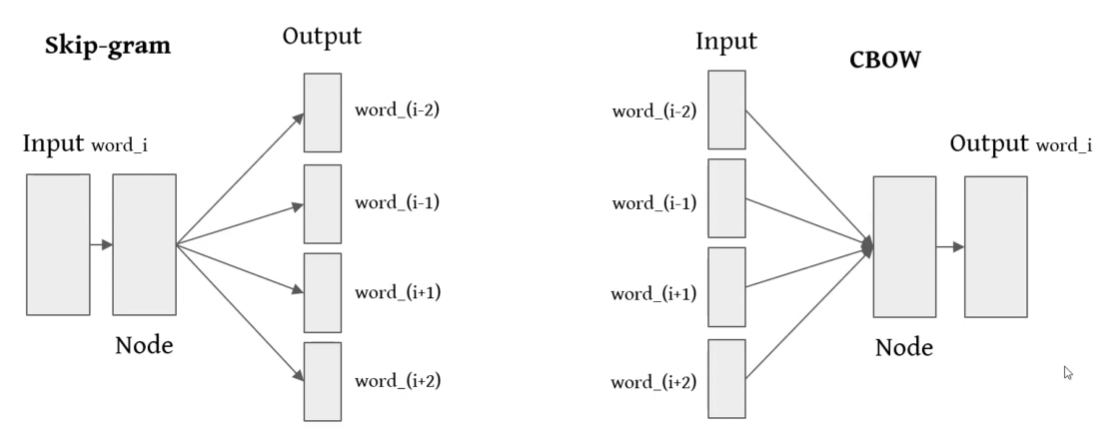

**4. GloVe:**

Global Vectors for Word Representation

Bring more semantic info, the distance between 2 vectors can be computed and have meaningful semantic similarity.

It is a unsupersived learning method, train faster and scaled will in huge dataset, derive the relationship between the words from statistics(co-occurence matrix)

Ref https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation


**Model architecture:**
1. Count and TF-IDF -> RidgeClassifier() about 79% acc
2. Count and TF-IDF -> logistic regression about 80% acc
3. GloVe -> logistic reg: 58% 
          ->  Basic LSTM: 78%%
   GloVe- 200d vector:  GRU 80%

#### Embedding 1 Count Vectorizer 

In [16]:
count_vectorizer = feature_extraction.text.CountVectorizer()
# example_train_vectors = count_vectorizer.fit_transform(train["text"][0:5])

# ## we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
# print(example_train_vectors[0].todense().shape)
# print(example_train_vectors[0].todense())

In [17]:
train_vectors = count_vectorizer.fit_transform(X_train)
test_submit_vectors = count_vectorizer.transform(df_test_submit['text'])

In [18]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        from sklearn.decomposition import PCA, TruncatedSVD
        import matplotlib.patches as mpatches
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['#CFB87C','#000000']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color=colors[0], label='Not')
            blue_patch = mpatches.Patch(color=colors[1], label='Real')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})
            


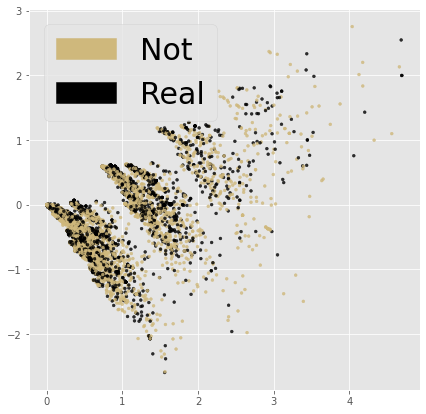

In [19]:
fig = plt.figure(figsize=(7, 7))          
plot_LSA(train_vectors, y_train)
plt.show()

#### Model for for count_vector

In [20]:
%%time

#clf = linear_model.RidgeClassifier()
clf = linear_model.LogisticRegression(C=0.8,max_iter=300)
scores = model_selection.cross_val_score(clf, train_vectors, y_train, cv=3, scoring="accuracy")
scores

CPU times: user 1.51 s, sys: 872 ms, total: 2.38 s
Wall time: 1.29 s


array([0.79903678, 0.79684764, 0.80201489])

Sample submission

In [21]:
# from sklearn.ensemble import HistGradientBoostingClassifier
# sample_submission = pd.read_csv("../input/tweet-test-sub/submission.csv")
# clf = linear_model.LogisticRegression(C=0.8,max_iter=300)
# clf = HistGradientBoostingClassifier()
# clf.fit(train_vectors, y_train)
# sample_submission["target"] = clf.predict(test_submit_vectors)

# sample_submission.to_csv("./submission.csv", index=False)
# print('sss')

### Embedding 2 TF-IDF

shape of X_train_tfidf (6851, 16610)
shape of X_test_sub_tfidf (3263, 10546)


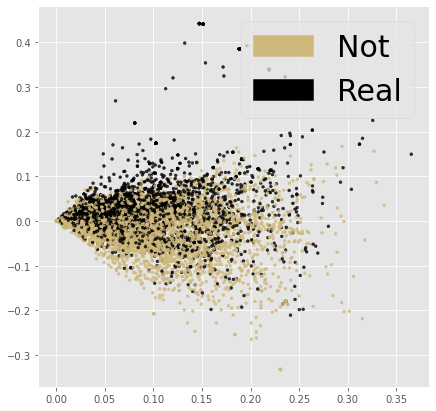

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.fit_transform(X_test)
X_test_sub_tfidf = tfidf_vectorizer.fit_transform(df_test_submit['text'])


print('shape of X_train_tfidf', X_train_tfidf.shape)
print('shape of X_test_sub_tfidf', X_test_sub_tfidf.shape)

fig = plt.figure(figsize=(7, 7))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

This plot shows the visualization of TF-IDF word vectors in 2D, we can see two classes are scatter at (0,0) and separate around right x axis, and some patterns in the dataset that can be sepatatd.

In [23]:
%%time
#logistic on TFIDF
from sklearn.svm import NuSVC
from sklearn.ensemble import AdaBoostClassifier

clf = linear_model.LogisticRegression()
clf = NuSVC()
#clf = GradientBoostingClassifier(loss='exponential',n_estimators=500)
scores = model_selection.cross_val_score(clf, X_train_tfidf, y_train, cv=3, scoring="accuracy")
scores

CPU times: user 13.5 s, sys: 147 ms, total: 13.7 s
Wall time: 13.8 s


array([0.79203152, 0.79553415, 0.80639509])

## Embedding 3 GloVe

https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

Prepare data first

In [24]:
from tqdm import tqdm
from nltk.tokenize import word_tokenize

#tweet = pd.read_csv('../input/nlptweet/train.csv')
train_tweets = df['text'].values #clean text
test_tweets = df_test_submit['text'].values
train_target = df['target'].values


In [25]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_tweets)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length


longest_train = max(train_tweets, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

from nltk.tokenize import word_tokenize
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

train_padded_sentences = pad_sequences(
    embed(train_tweets), 
    length_long_sentence, 
    padding='post'
)
test_padded_sentences = pad_sequences(
    embed(test_tweets), 
    length_long_sentence,
    padding='post'
)

train_padded_sentences.shape

(7613, 31)

#### Create a dictionary holding each word and its respective vector, 

For example a word 'the' is vectorize as a 200d vector.
And len of this dict is 400,000

This embedding_matrix hold the mapping form word to GloVe vector
will pass to embedding layer in RNN 

In [26]:
embedding_dict={}
dir = '../input/glovetwitter27b100dtxt/glove.twitter.27B.200d.txt'
#dir = '../input/glove6b/glove.6B.200d.txt'
with open(dir,'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors
f.close()

embedding_matrix = np.zeros((vocab_length, 200))  #same as GloveVec

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix.shape

(18105, 200)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    train_target, 
    test_size=0.1, random_state=10
)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)
print('embedding_matrix.shape', embedding_matrix.shape)

Shape of train (6851, 31)
Shape of Validation  (762, 31)
embedding_matrix.shape (18105, 200)


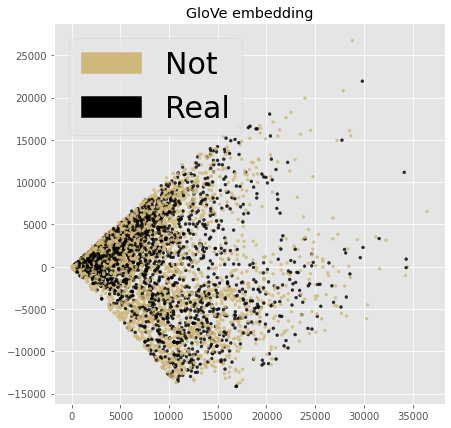

In [28]:
fig = plt.figure(figsize=(7, 7))          
plot_LSA(X_train, y_train)
plt.title('GloVe embedding')
plt.show()

### Step 4 Results and Analysis (35 pts)
Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

0. Try some classic machine learning model for GloVe, evem worse than simple count embedding:
   * logistic reg: 58%, 
   * Boosting: 65%
   * Adaboost 68%
   
1. Imporving and tunnig the Baseline RNN model, try to add more layers, reduce overfitting.
2. Find 'best' lr, dropout rate etc  for RNN
3. Thing that Work well and doesn't: 
    * Basic RNN: 1 layer 64 units： 78%
    * Adding bidirectional LSTM, batch norm, 1d pooling
    * GRU seems train a little better than LSTM
    * Try rmsprop and Adam.
    * NOT working, when training second model, 2 GRU and 2 dense layers were added, and when it reach epoch 7 or 8, val_acc start decrese while loss still decrease, which is a sign of model overfitting. So more regularization methods were use, and change 100d glove vector to 200d.
4. Result analysis in the end.

Baseline model using one layer of LSTM

### model 1 logistic reg

In [29]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
print('shape of x train', X_train.shape)
# reg 
clf = linear_model.LogisticRegression(max_iter=500)
scores = model_selection.cross_val_score(clf, X_train, y_train, cv=3, scoring="accuracy")

scores

shape of x train (6851, 31)
CPU times: user 630 ms, sys: 218 ms, total: 848 ms
Wall time: 430 ms


array([0.56260946, 0.55385289, 0.55759965])

### model 2 basicline RNN

In [30]:
#embedding layer takes word vectors matrix(above (20343, 100))
# into vector of fixed size so that can be feed into dense layer
from keras.initializers import Constant
from keras import layers

embedding = keras.layers.Embedding(input_dim=embedding_matrix.shape[0],
                                   output_dim=embedding_matrix.shape[1], # same as Glove vecotor
                                   #embeddings_initializer=Constant(embedding_matrix),
                                   weights = [embedding_matrix], 
                                   input_length=length_long_sentence)
                                   #trainable=True)

#### Try to imporve model

In [31]:
from tensorflow.keras.layers import Bidirectional
kernel_regularizer = tf.keras.regularizers.L1(0.01)

model = keras.models.Sequential([
    embedding,
    #layers.SpatialDropout1D(0.2), # drop entire feature map instead 1 element
    layers.Bidirectional(layers.GRU(units=length_long_sentence, dropout=0.5, 
                              recurrent_dropout=0.5,
                              return_sequences = True,
                              kernel_regularizer=kernel_regularizer,
                              recurrent_regularizer=kernel_regularizer)),
    keras.layers.LayerNormalization(),
    layers.GRU(units=length_long_sentence, dropout=0.5, 
                              recurrent_dropout=0.3,
                              return_sequences = True,
                              kernel_regularizer=kernel_regularizer,
                              recurrent_regularizer=kernel_regularizer),
    
    layers.GlobalMaxPool1D(),
    layers.BatchNormalization(),
    layers.Dense(100, activation='relu',
                 kernel_initializer="he_normal",
                 kernel_regularizer=kernel_regularizer),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(50, activation='relu',
                 kernel_initializer="he_normal",
                 kernel_regularizer=kernel_regularizer),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
      
    
])
model.summary()

2022-03-31 16:27:14.670046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 16:27:14.761732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 16:27:14.762507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 16:27:14.763640: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 200)           3621000   
_________________________________________________________________
bidirectional (Bidirectional (None, 31, 62)            43338     
_________________________________________________________________
layer_normalization (LayerNo (None, 31, 62)            124       
_________________________________________________________________
gru_1 (GRU)                  (None, 31, 31)            8835      
_________________________________________________________________
global_max_pooling1d (Global (None, 31)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31)                124       
_________________________________________________________________
dense (Dense)                (None, 100)               3

In [32]:
optimzer = keras.optimizers.Adam(learning_rate=1e-3)

model.compile(loss='binary_crossentropy',
              optimizer=optimzer,
              metrics=['accuracy'])

##################

epochs = 15
checkpoint = ModelCheckpoint(
    './model.h5', monitor = 'val_loss', 
    verbose = 1, save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', factor = 0.5, verbose = 1, 
    patience = 5, min_lr = 0.0001
)
history = model.fit(X_train,y_train,
                    batch_size=128,epochs=epochs ,
                    validation_data=(X_test,y_test),verbose=1)

2022-03-31 16:27:17.705022: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-03-31 16:27:25.948552: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


54/54 [==============================] - 29s 395ms/step - loss: 43.3018 - accuracy: 0.5306 - val_loss: 33.9468 - val_accuracy: 0.5866
Epoch 2/15
54/54 [==============================] - 21s 391ms/step - loss: 27.1800 - accuracy: 0.5790 - val_loss: 20.5974 - val_accuracy: 0.6969
Epoch 3/15
54/54 [==============================] - 20s 373ms/step - loss: 16.3730 - accuracy: 0.6306 - val_loss: 12.6689 - val_accuracy: 0.7349
Epoch 4/15
54/54 [==============================] - 20s 375ms/step - loss: 10.3447 - accuracy: 0.6825 - val_loss: 8.2074 - val_accuracy: 0.7559
Epoch 5/15
54/54 [==============================] - 20s 374ms/step - loss: 6.6975 - accuracy: 0.7151 - val_loss: 5.3257 - val_accuracy: 0.7585
Epoch 6/15
54/54 [==============================] - 20s 377ms/step - loss: 4.3678 - accuracy: 0.7377 - val_loss: 3.5814 - val_accuracy: 0.7559
Epoch 7/15
54/54 [==============================] - 21s 390ms/step - loss: 3.0060 - accuracy: 0.7432 - val_loss: 2.5489 - val_accuracy: 0.7441
Epo

In [33]:
model.save('./model.h5')

### Result

* Acc vs epoch plot
* Confusion martrix

In [34]:
from sklearn import metrics
y_pred_class = (model.predict(X_test) > 0.5).astype("int32")
y_pred_train = (model.predict(X_train) > 0.5).astype("int32")

print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))

report = classification_report(y_test, y_pred_class)
print(report)

Train: 0.8671726755218216
Test: 0.7952755905511811
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       407
           1       0.86      0.66      0.75       355

    accuracy                           0.80       762
   macro avg       0.81      0.79      0.79       762
weighted avg       0.81      0.80      0.79       762



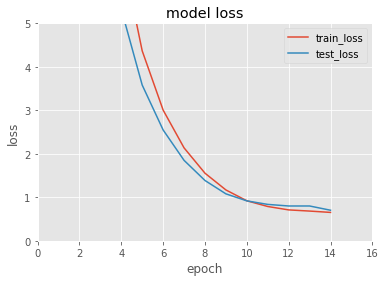

In [35]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylim(0,5)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xlim(0,epochs+1)
plt.legend(['train_loss', 'test_loss'], 
           loc='upper right')
plt.show()

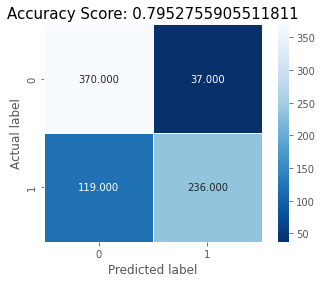

In [36]:
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns

cfm = confusion_matrix(y_test, y_pred_class)
acc = accuracy_score(y_test, y_pred_class)
sns.heatmap(cfm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc)
plt.title(all_sample_title, size = 15);

### Step 5 Conclusion (15 pts)
Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

1. Result and takeaways:
    * Logistic regression is a great method as a baseline model, it is very stable for different embedding, easy and fast to train, not much hyperparameters to tune, yet reach a good accuracy~80%.
    * Complex netword can lead to overfitting problem, we can use some data augmentation methods, better embedding or train less epochs.

2. Did and did not help to improve the performance:
      * Many factors state in step 4, but one more thing improve training is a larger batch size 64,128 will significantly increase training speed.

3. Try in future: 
   * Try a larger pretained word embedding, for this project glove.6B.100d was used(~300mb), in the future we can try the one with 300d .
   * Try some state of the art model, for example Bert and its varients.

___________________________________
Make submission file

In [37]:
sample_sub=pd.read_csv('../input/tweet-test-sub/submission.csv')

y_pre = (model.predict(test_padded_sentences) > 0.5).astype("int32") 
y_pre = np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('./submission-final.csv',index=False)

### Step 6
 
Produce Deliverables: High-Quality, Organized Jupyter Notebook Report, GitHub Repository, and screenshot of Kaggle leaderboard (30 points).

**github url**:  

https://github.com/carsonxie/Machine-Learning-Projects/tree/main/NLP%20Disaster%20Tweets%20Kaggle%20Mini-Project

----

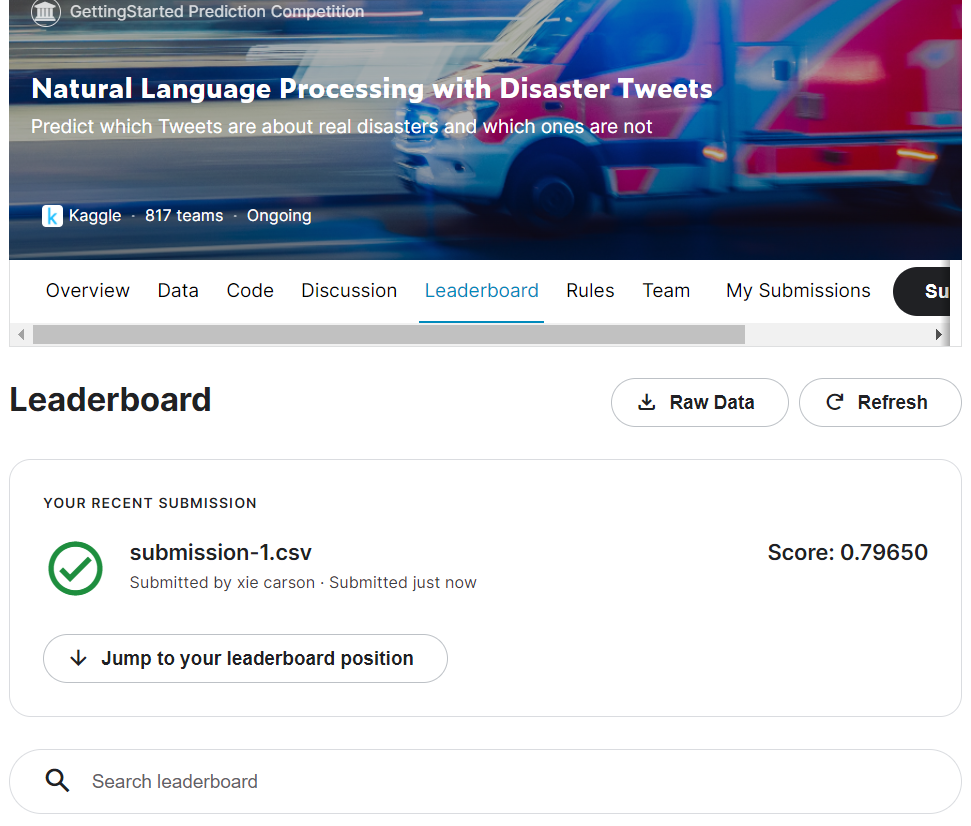

____
Reference notebooks

Ref: 
https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial/notebook

https://www.kaggle.com/code/shahules/basic-eda-cleaning-and-glove

All aroung: https://www.kaggle.com/code/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert

Bert: https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained

Glove: https://analyticsindiamag.com/hands-on-guide-to-word-embeddings-using-glove/